## <span style="color:turquoise"> Exercise 10: Travelling Salesman Problem w/ parallel computing </span>

In this exercise we expand on the previous one by implementing the Message Passing Interface (MPI) in our code in order to run multiple parallel processes and enhance the capabilities of our GA.

We chose task number 1:
1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 10 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.
Do you improve with respect using the same number of computing cores but with **independent GA searches** ?

which should be answered regarding an application of TSP to the 50 American Capitals.

### <span style="color:turquoise"> Fitness function </span>

Since raw data is given in longitude and latitude, the fitness function used is not the euclidean distance anymore, yet we opted for the haversine distance, i.e. the length of the great circle connecting two points on a sphere. Given US extension, it seemed more appropriate than euclidean distance.
$$
a = \sin^2\left(\frac{\Delta \text{lat}}{2}\right) + \cos(\text{lat1}) \cdot \cos(\text{lat2}) \cdot \sin^2\left(\frac{\Delta \text{lon}}{2}\right) \\
c = 2 \cdot \text{atan}\frac{\sqrt{a}}{ \sqrt{1 - a}} \\
\text{distance} = R_\text{earth} \cdot c

$$

But... the converge to a non local minimum was incredibly hard: solutions would always present a cross, which is syntom for optimization still to be done. 

After many hours of manually running the program, to understand ins and outs of the selection bias (we also tried a different scheme for the selection), probability parameters, tweaking with number of individuals and generation and going fancy mode (like designing an updating scheme to augment mutation probability and lower selection bias among the epochs, or implementing an injection of fresh new individuals at every generation that would substitute the less fit ones), we tried to change the fitness function. 

We went back to the L2 norm in the plane (considering longitude and latitude as planar coordinates): the idea was that, maybe, changing the cost landscape would make the optimization easier. And it proved so, since we stopped getting crosses since the first trial.

### <span style="color:turquoise"> Bidirectional communication among processes </span>

For the migration routine we chose to open communication (allow migration) between each pair of processes (continents).
Since all the processes are initialized with different seeds, exchanging genetic information between continents shall, in our opinion, improve the GA wrt the independent search: if at the moment of migration
- the average fitness of the best individuals of a continent is greater than the respective quantity in the other continent: the search will benefit from tha fact that the two processes have explored different spaces, but restart the search focusing more on more promising leads, maybe mixing it with new informations.
- if the average fitness of the best individuals is circa equal, but chromosomes are different: this means both continents are in a local minima. Mixing info can disrupt their actual conclusions and help the search furthermore!
- if the average fitness of the best individuals is circa equal, beacuse chromosomes are pretty the same: no harm is done, no advantage seems to be found.

In general the method is useful to avoid local minima (but that is true also for independent searches with same set of seeds), but mixing the information with migration leads to simultaneously new kind-of-crossover operations (width) and enhaced focus of resources on the continent lead that is more promising (depth).

The migrating (leaving) chromosome are selected from a population using the same selection strategy of the Selection Operator, just making sure that each individual can be extracted only once.

While the code is ready to run for indefinitely number of processes, unfortunately only two cores are available on the used laptop, thus the following considerations will be done using such setup.

### <span style="color:turquoise"> Results for 2 parallel independent searches </span>

We report a run of the two simulations (independent searches and with migrations) with the same parameters:

Nalleles = 50 \
popSize = 1000 \
selectionBias = 1.5 \
elitism = 4 \
pcrossover = 0.5 \
pmutation_pairPermutation = 0.07 \
pmutation_ClusterPermutation = 0.07 \
pmutation_Shift = 0.07 \
pmutation_Inversion = 0.07 \
Ngenerations = 10000 

In [1]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})

In [8]:
def importDataTSP(path, rank):
    fitness = np.loadtxt(path+'/out_fitness_'+rank+'.txt', skiprows=1)
    TSpath = np.loadtxt(path+'/out_path_'+rank+'.txt')
    locCities = np.loadtxt(path+'/input.in')
    return fitness, TSpath.astype(int), locCities

[]

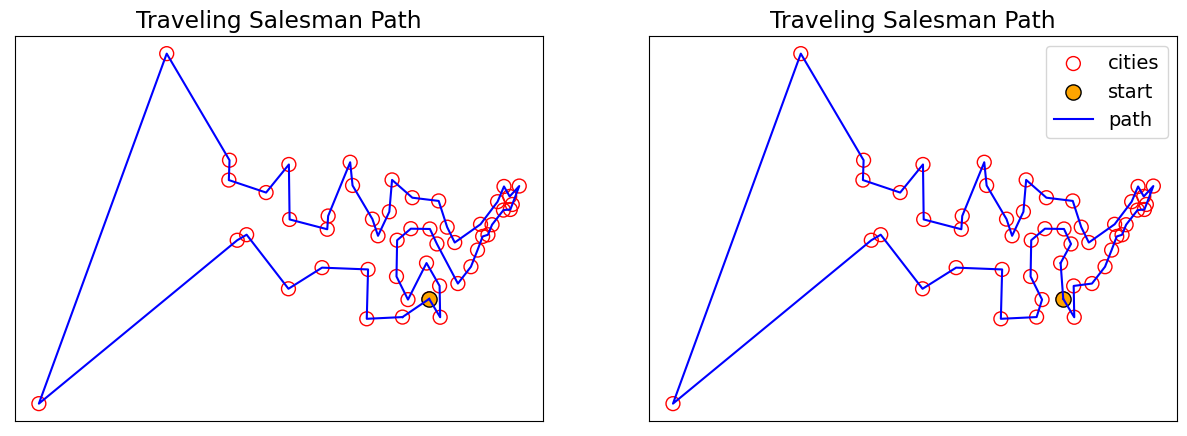

In [50]:

fitness0, TSpath0, locCities0 = importDataTSP("./4594_indep","0")
fitness1, TSpath1, locCities1 = importDataTSP("./4594_indep","1")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
axs = ax.flatten()

scatter = axs[0].scatter(locCities0[:,0], locCities0[:,1], marker="o",edgecolor='red', facecolor='none', s=100)
axs[0].scatter(locCities0[:,0][TSpath0[0]], locCities0[:,1][TSpath0[0]], marker="o",edgecolor='black', facecolor='orange', s=120)
axs[0].plot(locCities0[:,0][TSpath0], locCities0[:,1][TSpath0], c="blue", alpha=1, label='Progressive optimization')
axs[0].plot([locCities0[:,0][TSpath0[-1]],locCities0[:,0][TSpath0[0]]], [locCities0[:,1][TSpath0[-1]],locCities0[:,1][TSpath0[0]]], c="blue", alpha=1, label='Progressive optimization')

# Adding title and deactivating ticks on the axes
axs[0].set_title('Traveling Salesman Path')
axs[0].set_xticks([])  # Deactivate ticks on x-axis
axs[0].set_yticks([])  # Deactivate ticks on y-axis

axs[1].legend(["cities", "start", "path"])

scatter = axs[1].scatter(locCities1[:,0], locCities1[:,1], marker="o",edgecolor='red', facecolor='none', s=100)
axs[1].scatter(locCities1[:,0][TSpath1[0]], locCities1[:,1][TSpath1[0]], marker="o",edgecolor='black', facecolor='orange', s=120)
axs[1].plot(locCities1[:,0][TSpath1], locCities1[:,1][TSpath1], c="blue", alpha=1, label='Progressive optimization')
axs[1].plot([locCities1[:,0][TSpath1[-1]],locCities1[:,0][TSpath1[0]]], [locCities1[:,1][TSpath1[-1]],locCities1[:,1][TSpath1[0]]], c="blue", alpha=1, label='Progressive optimization')

# Adding title and deactivating ticks on the axes
axs[1].set_title('Traveling Salesman Path')
axs[1].set_xticks([])  # Deactivate ticks on x-axis
axs[1].set_yticks([])  # Deactivate ticks on y-axis

axs[1].legend(["cities", "start", "path"])

axs[1].set_title('Traveling Salesman Path')
axs[1].set_xticks([])  # Deactivate ticks on x-axis
axs[1].set_yticks([])  # Deactivate ticks on y-axis

best path core 0: 4654.69
best path core 1: 4594.84


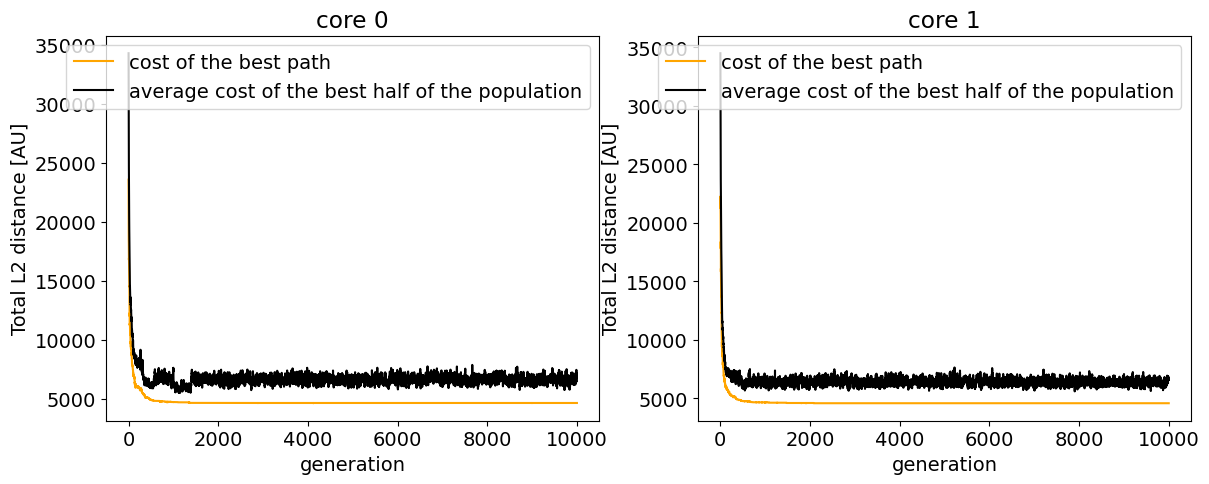

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
axs = ax.flatten()
axs[0].plot(range(10001), fitness0[:,0], c="orange")
axs[0].plot(range(10001), fitness0[:,1], c="black")

axs[0].legend(["cost of the best path", "average cost of the best half of the population"])
axs[0].set_title("core 0")
axs[0].set_ylabel("Total L2 distance [AU]")
axs[0].set_xlabel("generation")

axs[1].plot(range(10001), fitness1[:,0], c="orange")
axs[1].plot(range(10001), fitness1[:,1], c="black")

axs[1].legend(["cost of the best path", "average cost of the best half of the population"])
axs[1].set_title("core 1")
axs[1].set_ylabel("Total L2 distance [AU]")
axs[1].set_xlabel("generation")
print(f"best path core 0: {fitness0[-1,0]}")
print(f"best path core 1: {fitness1[-1,0]}")

### <span style="color:turquoise"> Results for 2 parallel continent with migrations </span>

Each continent exchanges 4 individuals each 100 migrations

[]

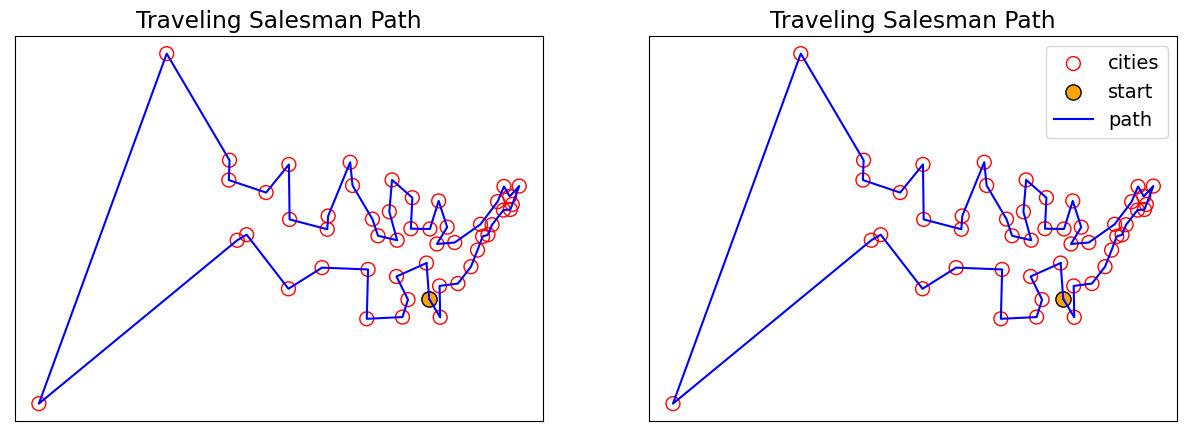

In [51]:

fitness0, TSpath0, locCities0 = importDataTSP("./4617_paral","0")
fitness1, TSpath1, locCities1 = importDataTSP("./4617_paral","1")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
axs = ax.flatten()

scatter = axs[0].scatter(locCities0[:,0], locCities0[:,1], marker="o",edgecolor='red', facecolor='none', s=100)
axs[0].scatter(locCities0[:,0][TSpath0[0]], locCities0[:,1][TSpath0[0]], marker="o",edgecolor='black', facecolor='orange', s=120)
axs[0].plot(locCities0[:,0][TSpath0], locCities0[:,1][TSpath0], c="blue", alpha=1, label='Progressive optimization')
axs[0].plot([locCities0[:,0][TSpath0[-1]],locCities0[:,0][TSpath0[0]]], [locCities0[:,1][TSpath0[-1]],locCities0[:,1][TSpath0[0]]], c="blue", alpha=1, label='Progressive optimization')

# Adding title and deactivating ticks on the axes
axs[0].set_title('Traveling Salesman Path')
axs[0].set_xticks([])  # Deactivate ticks on x-axis
axs[0].set_yticks([])  # Deactivate ticks on y-axis

axs[1].legend(["cities", "start", "path"])

scatter = axs[1].scatter(locCities1[:,0], locCities1[:,1], marker="o",edgecolor='red', facecolor='none', s=100)
axs[1].scatter(locCities1[:,0][TSpath1[0]], locCities1[:,1][TSpath1[0]], marker="o",edgecolor='black', facecolor='orange', s=120)
axs[1].plot(locCities1[:,0][TSpath1], locCities1[:,1][TSpath1], c="blue", alpha=1, label='Progressive optimization')
axs[1].plot([locCities1[:,0][TSpath1[-1]],locCities1[:,0][TSpath1[0]]], [locCities1[:,1][TSpath1[-1]],locCities1[:,1][TSpath1[0]]], c="blue", alpha=1, label='Progressive optimization')

# Adding title and deactivating ticks on the axes
axs[1].set_title('Traveling Salesman Path')
axs[1].set_xticks([])  # Deactivate ticks on x-axis
axs[1].set_yticks([])  # Deactivate ticks on y-axis

axs[1].legend(["cities", "start", "path"])

axs[1].set_title('Traveling Salesman Path')
axs[1].set_xticks([])  # Deactivate ticks on x-axis
axs[1].set_yticks([])  # Deactivate ticks on y-axis

best path core 0: 4617.12
best path core 1: 4617.12


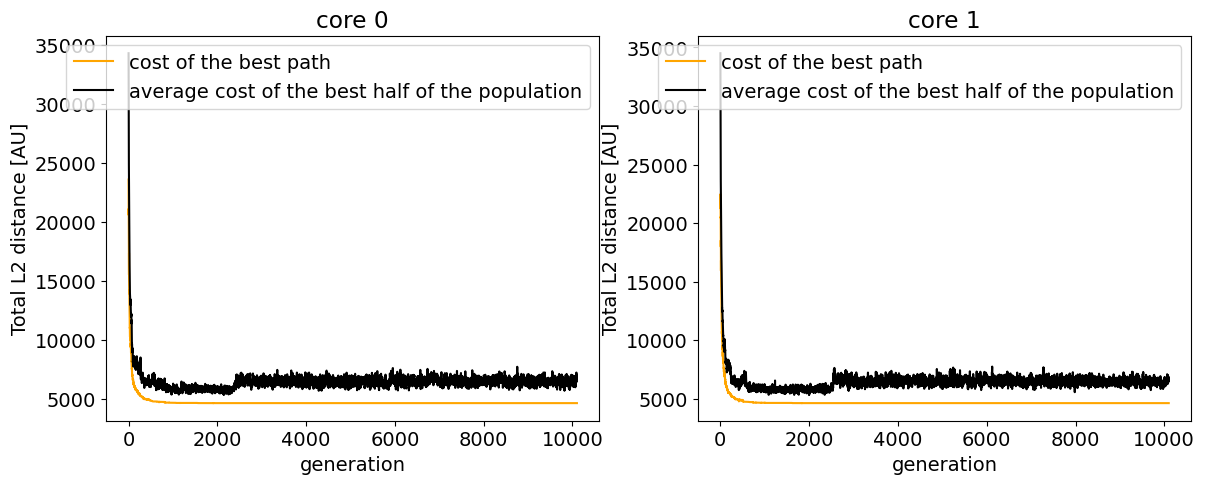

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
axs = ax.flatten()
axs[0].plot(range(10101), fitness0[:,0], c="orange")
axs[0].plot(range(10101), fitness0[:,1], c="black")

axs[0].legend(["cost of the best path", "average cost of the best half of the population"])
axs[0].set_title("core 0")
axs[0].set_ylabel("Total L2 distance [AU]")
axs[0].set_xlabel("generation")

axs[1].plot(range(10101), fitness1[:,0], c="orange")
axs[1].plot(range(10101), fitness1[:,1], c="black")

axs[1].legend(["cost of the best path", "average cost of the best half of the population"])
axs[1].set_title("core 1")
axs[1].set_ylabel("Total L2 distance [AU]")
axs[1].set_xlabel("generation")
print(f"best path core 0: {fitness0[-1,0]}")
print(f"best path core 1: {fitness1[-1,0]}")

We can see that the independent search has produced a better solution: We believe that is because, having only two processes running, the migrations settled the GA on a local minima. Instead we believe that, if one has more processes available, and so more different information to exchange, the continent strategy would benefit and have better results overall. \

That said even if the results aren't that different, we have reasons to believe that the global minimum was not found. It would be very interesting to investigate more on this GA. The first tools we would implement to try improving upon the results are: 
- more processes
- new and more crossover operators
- a solid updating scheme for the parameters
- hyperoptimization: i.e. automating the choice (and assessment) of the parameters to feed to the GA.